   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 15.2 MB/s eta 0:00:00
Mounted at /content/drive


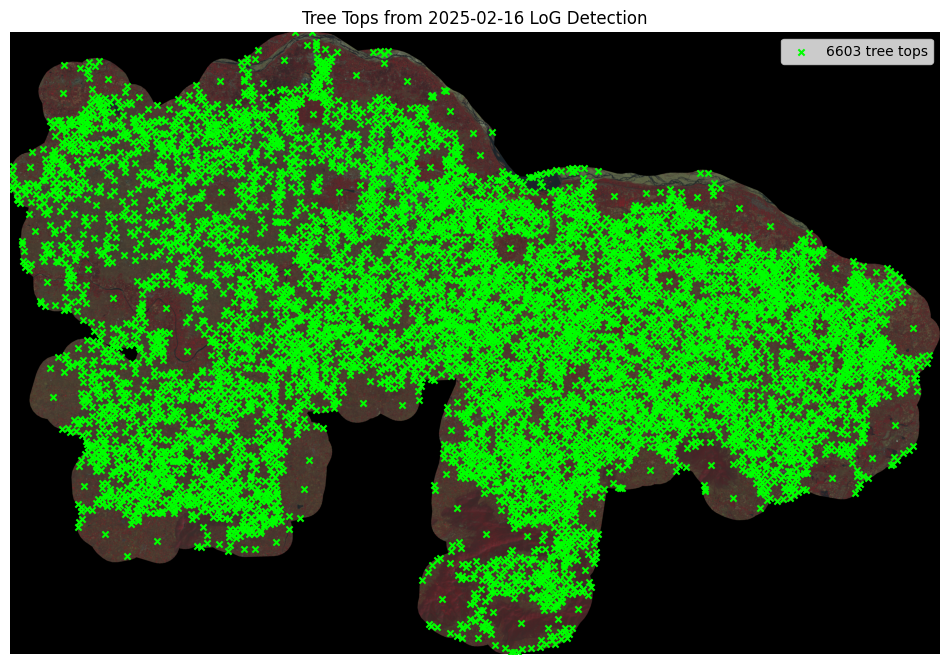

Detected 6603 trees → /content/drive/MyDrive/TreeProject/outputs_blob_16Feb2025/tree_locations_20250216.csv
Annotated image → /content/drive/MyDrive/TreeProject/outputs_blob_16Feb2025/annotated_20250216.png


In [ ]:
# ─── 0) Install dependencies ────────────────────────────────────────────────
!pip install rasterio scikit-image matplotlib numpy geopandas

# ─── 1) (Colab) Mount Drive ─────────────────────────────────────────────────
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_ROOT = '/content/drive/MyDrive/TreeProject'
except ImportError:
    DRIVE_ROOT = '.'

# ─── 2) Imports & Paths ───────────────────────────────────────────────────────
import os, csv
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import blob_log
from skimage.morphology import remove_small_objects, opening, closing, disk

IMAGE_PATH = os.path.join(DRIVE_ROOT,
    'Karur_FalseColor.tif'
)
OUTPUT_DIR = os.path.join(DRIVE_ROOT, 'outputs_blob_16Feb2025')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── 3) LoG Detection Params (physical) ──────────────────────────────────────
pixel_res     = 0.01    # 10 mm per pixel
min_sigma_m   = 0.1     # min crown radius ~0.1 m
max_sigma_m   = 2.0     # max crown radius ~2 m
num_sigma     = 12      # number of intermediate scales
threshold_rel = 0.05    # relative threshold (0.01–0.2)
overlap       = 0.4     # lower to split very close crowns

# convert to pixel units
min_sigma_px = min_sigma_m / pixel_res
max_sigma_px = max_sigma_m / pixel_res

# ─── 4) Load B8, B4, B2 at full res ──────────────────────────────────────────
with rasterio.open(IMAGE_PATH) as src:
    # band order in your false-color TIFF: [B8, B4, B2]
    b8, b4, b2 = src.read([1,2,3]).astype('float32')
    transform = src.transform
    crs = src.crs

# compute NDVI
ndvi = (b8 - b4) / (b8 + b4 + 1e-10)

# ─── 5) Smooth + Otsu mask to isolate vegetation ─────────────────────────────
ndvi_s = gaussian(ndvi, sigma=min_sigma_px/2)
thr   = threshold_otsu(ndvi_s)
veg   = ndvi_s > thr

# clean small artifacts (<0.2 m²) and smooth mask
min_area_px2 = int((0.2/pixel_res)**2)
veg = remove_small_objects(veg, min_size=min_area_px2)
veg = opening(veg, disk(int(0.1/pixel_res)))
veg = closing(veg, disk(int(0.1/pixel_res)))

# ─── 6) Run LoG blob detection on NDVI surface ────────────────────────────────
blobs = blob_log(
    ndvi_s,
    min_sigma=min_sigma_px,
    max_sigma=max_sigma_px,
    num_sigma=num_sigma,
    threshold=threshold_rel * ndvi_s.max(),
    overlap=overlap
)
# blobs: each row = (y, x, sigma)

# filter to veg mask
points = [(x, y) for y,x,_ in blobs if veg[int(y), int(x)]]

# ─── 7) Annotate on false-color composite for sanity check ───────────────────
# false-color display = [NIR, Red, Blue]
def norm(arr): return (arr - arr.min()) / np.ptp(arr)

rgb = np.stack([ norm(b8), norm(b4), norm(b2) ], axis=-1)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb)
xs, ys = zip(*points)
ax.scatter(xs, ys, s=20, c='lime', marker='x',
           label=f'{len(points)} tree tops')
ax.legend(loc='upper right')
ax.set_title('Tree Tops from 2025-02-16 LoG Detection')
ax.axis('off')
plt.show()
fig.savefig(os.path.join(OUTPUT_DIR, 'annotated_20250216.png'), dpi=300)

# ─── 8) Export lon/lat CSV ───────────────────────────────────────────────────
csv_out = os.path.join(OUTPUT_DIR, 'tree_locations_20250216.csv')
with open(csv_out, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['longitude','latitude'])
    for x,y in points:
        lon, lat = rasterio.transform.xy(transform, int(y), int(x))
        w.writerow([lon, lat])

print(f"Detected {len(points)} trees → {csv_out}")
print(f"Annotated image → {os.path.join(OUTPUT_DIR, 'annotated_20250216.png')}")


In [ ]:
# ─── 0) Install deps ─────────────────────────────────────────────────────────
!pip install --quiet rasterio numpy matplotlib torch torchvision tqdm geopandas faiss-cpu

# ─── 1) Mount Drive & Paths ──────────────────────────────────────────────────
import os, time, csv
from google.colab import drive

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')

DRIVE_ROOT  = '/content/drive/MyDrive/TreeProject'
IMAGE_PATH  = os.path.join(DRIVE_ROOT, 'Karur_Buffered_Sentinel2_FalseColor_2025-02-16.tif')
OUTPUT_DIR  = os.path.join(DRIVE_ROOT, 'trees_gpu_vectorized')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── 2) Imports & Params ─────────────────────────────────────────────────────
import numpy as np
import rasterio
import torch, torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import faiss   # CPU FAISS
from collections import Counter

# thresholds in metres
pixel_res   = 10.0
crown_r_m   = 2.0
NDVI_THR    = 0.3
block_m     = 20.0
linear_m    = 50.0
plant_cv    = 0.25
angle_tol   = 20.0

# derived in pixels
crown_r_px  = max(1, int(round(crown_r_m/pixel_res)))
block_px    = block_m / pixel_res
linear_px   = linear_m / pixel_res

# batch size
BATCH = 2048

# ─── 3) Load & Smooth NDVI on GPU ─────────────────────────────────────────────
t0 = time.time()
with rasterio.open(IMAGE_PATH) as src:
    b8, b4, b2 = src.read([1,2,3]).astype('float32')
    transform  = src.transform
    crs        = src.crs

ndvi   = (b8 - b4) / (b8 + b4 + 1e-10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t_ndvi = torch.from_numpy(ndvi[None,None]).to(device)

sigma = crown_r_px/2
K     = 2*crown_r_px+1
coords = torch.arange(K, device=device).float() - crown_r_px
g1     = torch.exp(-0.5*(coords/sigma)**2)
kernel = (g1[:,None]*g1[None,:]) / g1.sum()
kernel = kernel[None,None]

smoothed = F.conv2d(t_ndvi, kernel, padding=crown_r_px)[0,0]
print(f"NDVI smoothing: {time.time()-t0:.2f}s")

# ─── 4) Canopy mask & local-max ───────────────────────────────────────────────
t1 = time.time()
canopy    = smoothed >= NDVI_THR
pooled    = F.max_pool2d(smoothed[None,None], K, 1, crown_r_px)[0,0]
local_max = (smoothed == pooled) & canopy
print(f"Local-max detection: {time.time()-t1:.2f}s")

# ─── 5) Extract peaks ─────────────────────────────────────────────────────────
t2         = time.time()
peaks      = torch.nonzero(local_max, as_tuple=False)           # [P,2]
P          = peaks.shape[0]
coords_full= peaks[:, [1,0]].float()                            # [P,2]
print(f"Found {P:,} peaks in {time.time()-t2:.2f}s")

# ─── 6) Vectorized batch k-NN + classification ──────────────────────────────
t3       = time.time()
patterns = torch.empty(P, dtype=torch.int8, device=device)      # 0–3 codes

for start in range(0, P, BATCH):
    end     = min(start+BATCH, P)
    batch   = coords_full[start:end]                             # [B,2]
    dists   = torch.cdist(batch, coords_full)                    # [B,P]
    idxs    = torch.arange(start, end, device=device)
    dists[torch.arange(end-start,device=device), idxs] = float('inf')
    vals, nbr = torch.topk(dists, 3, dim=1, largest=False, sorted=False)
    d1 = vals[:,0].sqrt(); d2 = vals[:,1].sqrt(); d3 = vals[:,2].sqrt()
    neigh   = coords_full[nbr[:,:2]]                             # [B,2,2]

    vecs    = neigh - batch.unsqueeze(1)                         # [B,2,2]
    angs    = (torch.atan2(vecs[:,:,1], vecs[:,:,0]) * (180/np.pi) + 360) % 180
    ang_dev = (angs[:,0] - angs[:,1]).abs()                       # [B]
    cv      = vals.std(dim=1) / (vals.mean(dim=1)+1e-6)           # [B]

    is_block  = (d1<=block_px)&(d2<=block_px)
    is_plant  = (cv<=plant_cv)&(d1<=2*block_px)
    is_linear = (d1<=linear_px)&(d2<=linear_px)&(ang_dev<=angle_tol)

    cls = torch.full((end-start,), 3, device=device, dtype=torch.int8)
    cls[is_block]  = 0
    cls[is_plant]  = 1
    cls[is_linear] = 2

    patterns[start:end] = cls

print(f"Classification (vectorized): {time.time()-t3:.2f}s")

# ─── 7) Collect & count ──────────────────────────────────────────────────────
coords_np      = coords_full.cpu().numpy()
patterns_cpu   = patterns.cpu().numpy()
names          = np.array(['Block','Plantation','Linear','Scattered'])
labels         = names[patterns_cpu]

counts = Counter(labels)
print("Counts by class:", counts)

# ─── 8) Annotate & save PNG ──────────────────────────────────────────────────
rgb = np.stack([
    (b8 - b8.min())/np.ptp(b8),
    (b4 - b4.min())/np.ptp(b4),
    (b2 - b2.min())/np.ptp(b2),
], axis=-1)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb)
colors = {'Block':'red','Plantation':'magenta','Linear':'yellow','Scattered':'cyan'}
for cls in colors:
    sel = labels==cls
    ax.scatter(coords_np[sel,0], coords_np[sel,1],
               c=colors[cls], s=10, marker='x', label=cls)
ax.legend(loc='upper right')
ax.axis('off')
png_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized.png')
fig.savefig(png_out, dpi=300, bbox_inches='tight')
plt.close()

# ─── 9) Export CSV & Shapefile ───────────────────────────────────────────────
csv_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized.csv')
with open(csv_out, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['longitude','latitude','class'])
    for (x,y),lab in zip(coords_np, labels):
        lon, lat = rasterio.transform.xy(transform, int(y), int(x))
        w.writerow([lon, lat, lab])

gdf = gpd.GeoDataFrame(
    {'class': labels},
    geometry=[Point(rasterio.transform.xy(transform, int(y), int(x)))
              for x,y in coords_np],
    crs=crs
)
shp_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized.shp')
gdf.to_file(shp_out)

print("Done – outputs in", OUTPUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 74.1 MB/s eta 0:00:00
Mounted at /content/drive
NDVI smoothing: 

In [ ]:
# ─── 0) Install dependencies ─────────────────────────────────────────────────
!pip install --quiet rasterio numpy matplotlib torch torchvision tqdm geopandas faiss-cpu

# ─── 1) Mount Drive & Paths ──────────────────────────────────────────────────
import os, time, csv
from google.colab import drive

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')

DRIVE_ROOT  = '/content/drive/MyDrive/TreeProject'
IMAGE_PATH  = os.path.join(DRIVE_ROOT, 'Karur_Buffered_Sentinel2_FalseColor_2025-02-16.tif')
OUTPUT_DIR  = os.path.join(DRIVE_ROOT, 'trees_gpu_vectorized_with_counts')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── 2) Imports & Params ─────────────────────────────────────────────────────
import numpy as np
import rasterio
import torch, torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import faiss   # CPU‐based FAISS for k-NN
from collections import Counter

# thresholds in metres
pixel_res   = 10.0
crown_r_m   = 2.0
NDVI_THR    = 0.3
block_m     = 20.0
linear_m    = 50.0
plant_cv    = 0.25
angle_tol   = 20.0

# derived in pixels
crown_r_px  = max(1, int(round(crown_r_m / pixel_res)))
block_px    = block_m  / pixel_res
linear_px   = linear_m / pixel_res

# batch size for GPU classification
BATCH = 2048

# ─── 3) Load & Smooth NDVI on GPU ─────────────────────────────────────────────
t0 = time.time()
with rasterio.open(IMAGE_PATH) as src:
    b8, b4, b2 = src.read([1,2,3]).astype('float32')
    transform  = src.transform
    crs        = src.crs

ndvi   = (b8 - b4) / (b8 + b4 + 1e-10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t_ndvi = torch.from_numpy(ndvi[None,None]).to(device)

sigma = crown_r_px/2
K     = 2*crown_r_px + 1
coords = torch.arange(K, device=device).float() - crown_r_px
g1     = torch.exp(-0.5*(coords/sigma)**2)
kernel = (g1[:,None]*g1[None,:]) / g1.sum()
kernel = kernel[None,None]

smoothed = F.conv2d(t_ndvi, kernel, padding=crown_r_px)[0,0]
print(f"NDVI smoothing: {time.time()-t0:.2f}s")

# ─── 4) Canopy mask & local‐max ──────────────────────────────────────────────
t1     = time.time()
canopy = smoothed >= NDVI_THR
pooled = F.max_pool2d(smoothed.unsqueeze(0).unsqueeze(0),
                      kernel_size=K, stride=1, padding=crown_r_px)[0,0]
local_max = (smoothed == pooled) & canopy
print(f"Local‐max detection: {time.time()-t1:.2f}s")

# ─── 5) Extract peak coords ───────────────────────────────────────────────────
t2 = time.time()
peaks       = torch.nonzero(local_max, as_tuple=False)      # [P,2]
P           = peaks.shape[0]
coords_full = peaks[:, [1,0]].float()                       # [P,2] (x,y) on GPU
print(f"Found {P:,} peaks in {time.time()-t2:.2f}s")

# ─── 6) Perform k‐NN & classification in vectorized GPU batches ─────────────
t3       = time.time()
patterns = torch.empty(P, dtype=torch.int8, device=device)  # class codes: 0–3

for start in range(0, P, BATCH):
    end    = min(start + BATCH, P)
    batch  = coords_full[start:end]                           # [B,2]
    # compute all distances [B,P]
    dists  = torch.cdist(batch, coords_full)                  # [B,P]
    # mask self-distances
    idxs   = torch.arange(start, end, device=device)
    dists[torch.arange(end-start, device=device), idxs] = float('inf')
    # top 3 neighbors
    vals, nbrs = torch.topk(dists, 3, dim=1, largest=False, sorted=False)
    d1 = vals[:,0].sqrt(); d2 = vals[:,1].sqrt(); d3 = vals[:,2].sqrt()
    neigh = coords_full[nbrs[:,:2]]                           # [B,2,2]

    # compute angles and stats
    vecs    = neigh - batch.unsqueeze(1)                      # [B,2,2]
    angs    = (torch.atan2(vecs[:,:,1], vecs[:,:,0]) * (180/np.pi) + 360) % 180
    ang_dev = (angs[:,0] - angs[:,1]).abs()                   # [B]
    cv      = vals.std(dim=1) / (vals.mean(dim=1) + 1e-6)     # [B]

    # classification rules
    is_block  = (d1 <= block_px) & (d2 <= block_px)
    is_plant  = (cv <= plant_cv) & (d1 <= 2*block_px)
    is_linear = (d1 <= linear_px) & (d2 <= linear_px) & (ang_dev <= angle_tol)

    cls = torch.full((end-start,), 3, device=device, dtype=torch.int8)  # default=3 (Scattered)
    cls[is_block]  = 0
    cls[is_plant]  = 1
    cls[is_linear] = 2

    patterns[start:end] = cls

print(f"Classification (vectorized): {time.time()-t3:.2f}s")

# ─── 7) Collect results & count ──────────────────────────────────────────────
coords_np    = coords_full.cpu().numpy()    # shape [P,2]
pat_cpu      = patterns.cpu().numpy()       # class codes
class_names  = np.array(['Block','Plantation','Linear','Scattered'])
labels       = class_names[pat_cpu]
counts       = Counter(labels)
print("Counts by class:", counts)

# ─── 8) Annotate & save PNG with legend counts ───────────────────────────────
rgb = np.stack([
    (b8 - b8.min()) / np.ptp(b8),
    (b4 - b4.min()) / np.ptp(b4),
    (b2 - b2.min()) / np.ptp(b2),
], axis=-1)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb)
ax.axis('off')

colors = {'Block':'red','Plantation':'magenta','Linear':'yellow','Scattered':'cyan'}
for cls, col in colors.items():
    sel = labels == cls
    ax.scatter(coords_np[sel,0], coords_np[sel,1],
               c=col, s=10, marker='x',
               label=f"{cls} ({counts[cls]:,})")

legend = ax.legend(loc='upper right', title="Class (count)", framealpha=0.7)
plt.tight_layout()
png_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized_with_counts.png')
fig.savefig(png_out, dpi=300, bbox_inches='tight')
plt.close()

# ─── 9) Export CSV & Shapefile ────────────────────────────────────────────────
csv_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized_with_counts.csv')
with open(csv_out, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['longitude','latitude','class'])
    for (x,y), lab in zip(coords_np, labels):
        lon, lat = rasterio.transform.xy(transform, int(y), int(x))
        w.writerow([lon, lat, lab])

gdf = gpd.GeoDataFrame(
    {'class': labels},
    geometry=[Point(rasterio.transform.xy(transform, int(y), int(x)))
              for x,y in coords_np],
    crs=crs
)
shp_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized_with_counts.shp')
gdf.to_file(shp_out)

print("Done – outputs in", OUTPUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 64.2 MB/s eta 0:00:00
Mounted at /content/drive
NDVI smoothing: 

In [ ]:
# ─── 0) Install dependencies ─────────────────────────────────────────────────
!pip install --quiet rasterio numpy matplotlib torch torchvision tqdm geopandas faiss-cpu

# ─── 1) Mount Drive & Paths ──────────────────────────────────────────────────
import os, time, csv
from google.colab import drive

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')

DRIVE_ROOT  = '/content/drive/MyDrive/TreeProject'
IMAGE_PATH  = os.path.join(DRIVE_ROOT, 'Karur_Buffered_Sentinel2_FalseColor_2025-02-16.tif')
OUTPUT_DIR  = os.path.join(DRIVE_ROOT, 'trees_gpu_vectorized_with_dots_total')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── 2) Imports & Params ─────────────────────────────────────────────────────
import numpy as np
import rasterio
import torch, torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import faiss   # CPU FAISS for k-NN
from collections import Counter

# thresholds in metres
pixel_res   = 10.0
crown_r_m   = 2.0
NDVI_THR    = 0.3
block_m     = 20.0
linear_m    = 50.0
plant_cv    = 0.25
angle_tol   = 20.0

# derived in pixels
crown_r_px  = max(1, int(round(crown_r_m / pixel_res)))
block_px    = block_m  / pixel_res
linear_px   = linear_m / pixel_res

# batch size for GPU classification
BATCH = 2048

# ─── 3) Load & Smooth NDVI on GPU ─────────────────────────────────────────────
t0 = time.time()
with rasterio.open(IMAGE_PATH) as src:
    b8, b4, b2 = src.read([1,2,3]).astype('float32')
    transform  = src.transform
    crs        = src.crs

ndvi   = (b8 - b4) / (b8 + b4 + 1e-10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t_ndvi = torch.from_numpy(ndvi[None,None]).to(device)

sigma = crown_r_px/2
K     = 2*crown_r_px + 1
coords = torch.arange(K, device=device).float() - crown_r_px
g1     = torch.exp(-0.5*(coords/sigma)**2)
kernel = (g1[:,None]*g1[None,:]) / g1.sum()
kernel = kernel[None,None]

smoothed = F.conv2d(t_ndvi, kernel, padding=crown_r_px)[0,0]
print(f"NDVI smoothing: {time.time()-t0:.2f}s")

# ─── 4) Canopy mask & local-max ───────────────────────────────────────────────
t1     = time.time()
canopy = smoothed >= NDVI_THR
pooled = F.max_pool2d(smoothed.unsqueeze(0).unsqueeze(0),
                      kernel_size=K, stride=1, padding=crown_r_px)[0,0]
local_max = (smoothed == pooled) & canopy
print(f"Local-max detection: {time.time()-t1:.2f}s")

# ─── 5) Extract peak coords ───────────────────────────────────────────────────
t2 = time.time()
peaks       = torch.nonzero(local_max, as_tuple=False)   # [P,2]
P           = peaks.shape[0]
coords_full = peaks[:, [1,0]].float()                    # [P,2] = (x,y) on GPU
print(f"Found {P:,} peaks in {time.time()-t2:.2f}s")

# ─── 6) GPU-vectorized k-NN & classification ─────────────────────────────────
t3       = time.time()
patterns = torch.empty(P, dtype=torch.int8, device=device)  # codes 0–3

for start in range(0, P, BATCH):
    end    = min(start + BATCH, P)
    batch  = coords_full[start:end]                          # [B,2]
    dists  = torch.cdist(batch, coords_full)                 # [B,P]
    idxs   = torch.arange(start, end, device=device)
    dists[torch.arange(end-start,device=device), idxs] = float('inf')
    vals, nbrs = torch.topk(dists, 3, dim=1, largest=False, sorted=False)
    d1 = vals[:,0].sqrt(); d2 = vals[:,1].sqrt(); d3 = vals[:,2].sqrt()
    neigh = coords_full[nbrs[:,:2]]                          # [B,2,2]

    vecs    = neigh - batch.unsqueeze(1)                     # [B,2,2]
    angs    = (torch.atan2(vecs[:,:,1], vecs[:,:,0]) * (180/np.pi) + 360) % 180
    ang_dev = (angs[:,0] - angs[:,1]).abs()                  # [B]
    cv      = vals.std(dim=1) / (vals.mean(dim=1) + 1e-6)    # [B]

    is_block  = (d1<=block_px) & (d2<=block_px)
    is_plant  = (cv<=plant_cv) & (d1<=2*block_px)
    is_linear = (d1<=linear_px)&(d2<=linear_px)&(ang_dev<=angle_tol)

    cls = torch.full((end-start,), 3, device=device, dtype=torch.int8)
    cls[is_block]  = 0
    cls[is_plant]  = 1
    cls[is_linear] = 2

    patterns[start:end] = cls

print(f"Classification (vectorized): {time.time()-t3:.2f}s")

# ─── 7) Collect & count ──────────────────────────────────────────────────────
coords_np    = coords_full.cpu().numpy()
pat_cpu      = patterns.cpu().numpy()
class_names  = np.array(['Block','Plantation','Linear','Scattered'])
labels       = class_names[pat_cpu]
counts       = Counter(labels)
total_count  = P
print("Counts by class:", counts)
print(f"Total trees: {total_count:,}")

# ─── 8) Annotate map with dots, counts & total ───────────────────────────────
rgb = np.stack([
    (b8 - b8.min())/np.ptp(b8),
    (b4 - b4.min())/np.ptp(b4),
    (b2 - b2.min())/np.ptp(b2),
], axis=-1)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb)
ax.axis('off')

# plot each class
colors = {'Block':'red','Plantation':'magenta','Linear':'yellow','Scattered':'cyan'}
for cls, col in colors.items():
    sel = labels == cls
    ax.scatter(
        coords_np[sel,0], coords_np[sel,1],
        c=col, s=5, marker='.',
        label=f"{cls} ({counts[cls]:,})"
    )

# add total count as a title
ax.set_title(f"Total Trees: {total_count:,}", fontsize=16)

# legend with counts
legend = ax.legend(loc='upper right', title="Class (count)", framealpha=0.7)

png_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized_with_dots_total.png')
fig.savefig(png_out, dpi=300, bbox_inches='tight')
plt.close()

# ─── 9) Export CSV & Shapefile ────────────────────────────────────────────────
csv_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized_with_dots_total.csv')
with open(csv_out, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['longitude','latitude','class'])
    for (x,y), lab in zip(coords_np, labels):
        lon, lat = rasterio.transform.xy(transform, int(y), int(x))
        w.writerow([lon, lat, lab])

gdf = gpd.GeoDataFrame(
    {'class': labels},
    geometry=[Point(rasterio.transform.xy(transform, int(y), int(x)))
              for x,y in coords_np],
    crs=crs
)
shp_out = os.path.join(OUTPUT_DIR, 'trees_gpu_vectorized_with_dots_total.shp')
gdf.to_file(shp_out)

print("Done – outputs in", OUTPUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 73.0 MB/s eta 0:00:00
Mounted at /content/drive
NDVI smoothing: 5.

In [ ]:
# ─── 0) Install dependencies ─────────────────────────────────────────────────
!pip install --quiet rasterio numpy matplotlib torch torchvision tqdm geopandas faiss-cpu

# ─── 1) Mount Drive & Paths ──────────────────────────────────────────────────
import os, time, csv
from google.colab import drive

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')

DRIVE_ROOT  = '/content/drive/MyDrive/TreeProject'
IMAGE_PATH  = os.path.join(DRIVE_ROOT, 'Karur_Buffered_Sentinel2_FalseColor_2025-02-16.tif')
OUTPUT_DIR  = os.path.join(DRIVE_ROOT, 'trees_gpu_nopruning')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ─── 2) Imports & Params ─────────────────────────────────────────────────────
import numpy as np
import rasterio
import torch, torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import faiss
from collections import Counter

pixel_res   = 10.0
crown_r_m   = 2.0
NDVI_THR    = 0.3
block_m     = 20.0
linear_m    = 50.0
plant_cv    = 0.25
angle_tol   = 20.0

crown_r_px  = max(1, int(round(crown_r_m / pixel_res)))
block_px    = block_m / pixel_res
linear_px   = linear_m / pixel_res
BATCH       = 2048

# ─── 3) Load & Smooth NDVI on GPU ─────────────────────────────────────────────
t0 = time.time()
with rasterio.open(IMAGE_PATH) as src:
    b8, b4, b2 = src.read([1,2,3]).astype('float32')
    transform  = src.transform
    crs        = src.crs

ndvi = (b8 - b4) / (b8 + b4 + 1e-10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t_ndvi = torch.from_numpy(ndvi[None,None]).to(device)

sigma = crown_r_px / 2
K = 2 * crown_r_px + 1
coords = torch.arange(K, device=device).float() - crown_r_px
g1 = torch.exp(-0.5 * (coords/sigma)**2)
kernel = (g1[:,None] * g1[None,:]) / g1.sum()
kernel = kernel[None,None]

smoothed = F.conv2d(t_ndvi, kernel, padding=crown_r_px)[0,0]
print(f"NDVI smoothing: {time.time()-t0:.2f}s")

# ─── 4) Canopy mask & local-max ───────────────────────────────────────────────
t1 = time.time()
canopy = smoothed >= NDVI_THR
pooled = F.max_pool2d(smoothed.unsqueeze(0).unsqueeze(0),
                      kernel_size=K, stride=1, padding=crown_r_px)[0,0]
local_max = (smoothed == pooled) & canopy
print(f"Local-max detection: {time.time()-t1:.2f}s")

# ─── 5) Extract peak coords ───────────────────────────────────────────────────
t2 = time.time()
peaks = torch.nonzero(local_max, as_tuple=False)
P = peaks.shape[0]
print(f"Found {P:,} peaks in {time.time()-t2:.2f}s")

# ─── 6) Classification via GPU k-NN ───────────────────────────────────────────
t3 = time.time()
coords_full = peaks[:, [1,0]].float().to(device)
patterns = torch.empty(P, dtype=torch.int8, device=device)

for start in range(0, P, BATCH):
    end = min(start + BATCH, P)
    batch = coords_full[start:end]
    dists = torch.cdist(batch, coords_full)
    idxs  = torch.arange(start, end, device=device)
    dists[torch.arange(end-start), idxs] = float('inf')
    vals, nbrs = torch.topk(dists, 3, dim=1, largest=False, sorted=False)

    d1 = vals[:,0].sqrt(); d2 = vals[:,1].sqrt(); d3 = vals[:,2].sqrt()
    neigh = coords_full[nbrs[:,:2]]

    vecs = neigh - batch.unsqueeze(1)
    angs = (torch.atan2(vecs[:,:,1], vecs[:,:,0]) * (180/np.pi) + 360) % 180
    ang_dev = (angs[:,0] - angs[:,1]).abs()
    cv = vals.std(dim=1) / (vals.mean(dim=1) + 1e-6)

    is_block  = (d1<=block_px) & (d2<=block_px)
    is_plant  = (cv<=plant_cv) & (d1<=2*block_px)
    is_linear = (d1<=linear_px)&(d2<=linear_px)&(ang_dev<=angle_tol)

    cls = torch.full((end-start,), 3, device=device, dtype=torch.int8)
    cls[is_block]  = 0
    cls[is_plant]  = 1
    cls[is_linear] = 2

    patterns[start:end] = cls

print(f"Classification (vectorized): {time.time()-t3:.2f}s")

# ─── 7) Collect & count ───────────────────────────────────────────────────────
coords_np = coords_full.cpu().numpy()
pat_cpu = patterns.cpu().numpy()
class_names = np.array(['Block','Plantation','Linear','Scattered'])
labels = class_names[pat_cpu]
counts = Counter(labels)
total_count = P
print("Counts by class:", counts)
print(f"Total trees: {total_count:,}")

# ─── 8) Annotated Map ─────────────────────────────────────────────────────────
rgb = np.stack([
    (b8 - b8.min())/np.ptp(b8),
    (b4 - b4.min())/np.ptp(b4),
    (b2 - b2.min())/np.ptp(b2),
], axis=-1)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb)
ax.axis('off')

colors = {'Block':'red','Plantation':'magenta','Linear':'yellow','Scattered':'cyan'}
for cls, col in colors.items():
    sel = labels == cls
    ax.scatter(coords_np[sel,0], coords_np[sel,1], c=col, s=5, marker='.', label=f"{cls} ({counts[cls]:,})")

ax.set_title(f"Total Trees: {total_count:,}", fontsize=16)
ax.legend(loc='upper right', title="Class (count)", framealpha=0.7)

fig.savefig(os.path.join(OUTPUT_DIR, 'trees_gpu_nopruning.png'), dpi=300, bbox_inches='tight')
plt.close()

# ─── 9) Export CSV & Shapefile ────────────────────────────────────────────────
csv_out = os.path.join(OUTPUT_DIR, 'trees_gpu_nopruning.csv')
with open(csv_out, 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['longitude','latitude','class'])
    for (x,y), lab in zip(coords_np, labels):
        lon, lat = rasterio.transform.xy(transform, int(y), int(x))
        w.writerow([lon, lat, lab])

gdf = gpd.GeoDataFrame(
    {'class': labels},
    geometry=[Point(rasterio.transform.xy(transform, int(y), int(x))) for x,y in coords_np],
    crs=crs
)
gdf.to_file(os.path.join(OUTPUT_DIR, 'trees_gpu_nopruning.shp'))

print("Done – outputs in", OUTPUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 245.2 MB/s eta 0:00:01

In [ ]:
# ─── 0) Install dependencies ─────────────────────────────────────────────────
!pip install --quiet rasterio geopandas shapely numpy scikit-image scikit-learn torch torchvision segmentation-models-pytorch albumentations tqdm
# ─── 1) Mount Google Drive & set up paths ────────────────────────────────────
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

TIF      = "/content/drive/MyDrive/TreeProject/Karur_FalseColor.tif"
WORKDIR  = "/content/drive/MyDrive/TreeProject/ndvi_seg"
os.makedirs(WORKDIR, exist_ok=True)

ANN_TIF  = os.path.join(WORKDIR, "ndvi_mask.tif")
WEIGHTS  = os.path.join(WORKDIR, "unet_ndvi.pth")
CROWNS   = os.path.join(WORKDIR, "tree_crowns.shp")
PATCHES  = os.path.join(WORKDIR, "tree_pattern_patches.shp")
# ─── 2) Compute NDVI & save binary canopy mask ───────────────────────────────
import rasterio, numpy as np
from skimage.morphology import remove_small_objects, opening, closing, disk

with rasterio.open(TIF) as src:
    nir, red = src.read(1).astype(float), src.read(2).astype(float)
    meta, transform, crs = src.meta.copy(), src.transform, src.crs

ndvi = (nir - red) / (nir + red + 1e-8)
mask = ndvi >= 0.3
mask = remove_small_objects(mask, min_size=100)
mask = opening(mask, disk(2))
mask = closing(mask, disk(2))

meta.update(count=1, dtype="uint8")
with rasterio.open(ANN_TIF, "w", **meta) as dst:
    dst.write(mask.astype("uint8"), 1)
print("Saved NDVI mask →", ANN_TIF)
# ─── 3) Create Dataset & DataLoader with tiling & augmentations ─────────────
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import torchvision.transforms.functional as TF
import rasterio
import numpy as np

class TileDataset(Dataset):
    def __init__(self, img_tif, mask_tif, tile=512, transforms=None):
        self.img = rasterio.open(img_tif).read([1,2,3]).astype("float32")
        self.mask = rasterio.open(mask_tif).read(1).astype("uint8")
        self.tile = tile
        self.transforms = transforms
        H,W = self.mask.shape
        self.nx = (W + tile - 1)//tile
        self.ny = (H + tile - 1)//tile

    def __len__(self):
        return self.nx * self.ny

    def __getitem__(self, idx):
        x, y = idx % self.nx, idx // self.nx
        x0, y0 = x*self.tile, y*self.tile
        x1, y1 = min(x0+self.tile, self.mask.shape[1]), min(y0+self.tile, self.mask.shape[0])
        img_patch = self.img[:, y0:y1, x0:x1].transpose(1,2,0)
        mask_patch = self.mask[y0:y0+(y1-y0), x0:x0+(x1-x0)]
        ph, pw = self.tile-(y1-y0), self.tile-(x1-x0)
        img_patch = np.pad(img_patch, ((0,ph),(0,pw),(0,0)), constant_values=0)
        mask_patch = np.pad(mask_patch, ((0,ph),(0,pw)), constant_values=0)
        if self.transforms:
            aug = self.transforms(image=img_patch, mask=mask_patch)
            img_patch, mask_patch = aug["image"], aug["mask"]
        return TF.to_tensor(img_patch), torch.from_numpy(mask_patch[None]).float()

transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

ds = TileDataset(TIF, ANN_TIF, transforms=transforms)
loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=2)
# ─── 4) Train a U-Net on the NDVI mask ────────────────────────────────────────
import segmentation_models_pytorch as smp
from torch import optim, nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(5):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        total += loss.item()
    print(f"Epoch {epoch+1}/5 Loss: {total/len(loader):.4f}")

torch.save(model.state_dict(), WEIGHTS)
print("Saved weights →", WEIGHTS)
# ─── 5) Inference: build full-scene mask with clipping ───────────────────────
model.eval()
import numpy as np

with rasterio.open(ANN_TIF) as src:
    H, W = src.height, src.width

full_prob = np.zeros((H, W), dtype=float)
with torch.no_grad():
    for idx in range(len(ds)):
        xb, _ = ds[idx]
        xb = xb.unsqueeze(0).to(device)
        p = model(xb).sigmoid()[0,0].cpu().numpy()  # (512,512)
        x, y = idx % ds.nx, idx // ds.nx
        x0, y0 = x*ds.tile, y*ds.tile
        h_real = min(ds.tile, H - y0)
        w_real = min(ds.tile, W - x0)
        full_prob[y0:y0+h_real, x0:x0+w_real] = p[:h_real, :w_real]

pred_mask = full_prob > 0.5
# ─── 6) Split crowns & vectorize per-tree polygons ─────────────────────────
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

# watershed
dist = ndi.distance_transform_edt(pred_mask)
peaks = peak_local_max(dist, labels=pred_mask, min_distance=5)
markers = np.zeros_like(dist, int)
for i,(r,c) in enumerate(peaks,1):
    markers[r,c] = i
labels = watershed(-dist, markers, mask=pred_mask)

# ensure integer dtype
labels = labels.astype(np.int32)

geoms, ids = [], []
for geom_json, val in shapes(labels, mask=labels>0, transform=transform):
    geoms.append(shape(geom_json))
    ids.append(int(val))

gdf = gpd.GeoDataFrame({"tree_id":ids}, geometry=geoms, crs=crs)
gdf.to_file(CROWNS)
print("Saved tree crown polygons →", CROWNS)
# ─── 7) Cluster crowns & classify patterns ──────────────────────────────────
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from shapely.geometry import MultiPoint

gdf["centroid"] = gdf.geometry.centroid
pts = np.vstack([gdf.centroid.x, gdf.centroid.y]).T

clusters = DBSCAN(eps=50/10.0, min_samples=2).fit_predict(pts)
gdf["cluster"] = clusters

patches = []
for cid, grp in gdf.groupby("cluster"):
    coords = np.vstack([grp.centroid.x, grp.centroid.y]).T
    if cid == -1:
        for poly in grp.geometry:
            patches.append({"pattern":"Scattered","geometry":poly})
    else:
        hull = MultiPoint(coords).convex_hull
        area = hull.area
        minx,miny,maxx,maxy = hull.bounds
        aspect = max(maxx-minx, maxy-miny)/(min(maxx-minx, maxy-miny)+1e-6)
        if len(coords)>=3:
            d,_ = NearestNeighbors(n_neighbors=3).fit(coords).kneighbors(coords)
            cv = np.std(d[:,1])/(np.mean(d[:,1])+1e-6)
        else:
            cv = np.inf

        if aspect > 5.0:
            pat="Linear"
        elif area >= 5000 and hull.area/area > 0.85:
            pat="Block"
        elif 1000 <= area < 5000 and cv < 0.25:
            pat="Plantation"
        else:
            pat="Scattered"

        patches.append({"pattern":pat,"geometry":hull})

patch_gdf = gpd.GeoDataFrame(patches, crs=crs)
patch_gdf.to_file(PATCHES)
print("Saved classified patches →", PATCHES)
print(patch_gdf.pattern.value_counts())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.7 MB/s eta 0:00:00
Mounted at /content/drive
Saved NDVI ma

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/5 Loss: 0.5381
Epoch 2/5 Loss: 0.3338
Epoch 3/5 Loss: 0.2626
Epoch 4/5 Loss: 0.2156
Epoch 5/5 Loss: 0.1897
Saved weights → /content/drive/MyDrive/TreeProject/ndvi_seg/unet_ndvi.pth
Saved tree crown polygons → /content/drive/MyDrive/TreeProject/ndvi_seg/tree_crowns.shp


<ipython-input-2-2ae0f83126cf>:153: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
<ipython-input-2-2ae0f83126cf>:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pts = np.vstack([gdf.centroid.x, gdf.centroid.y]).T
<ipython-input-2-2ae0f83126cf>:161: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.vstack([grp.centroid.x, grp.centroid.y]).T


Saved classified patches → /content/drive/MyDrive/TreeProject/ndvi_seg/tree_pattern_patches.shp
pattern
Scattered    1
Name: count, dtype: int64


Detected 47850 crowns
Clusters: (array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172,

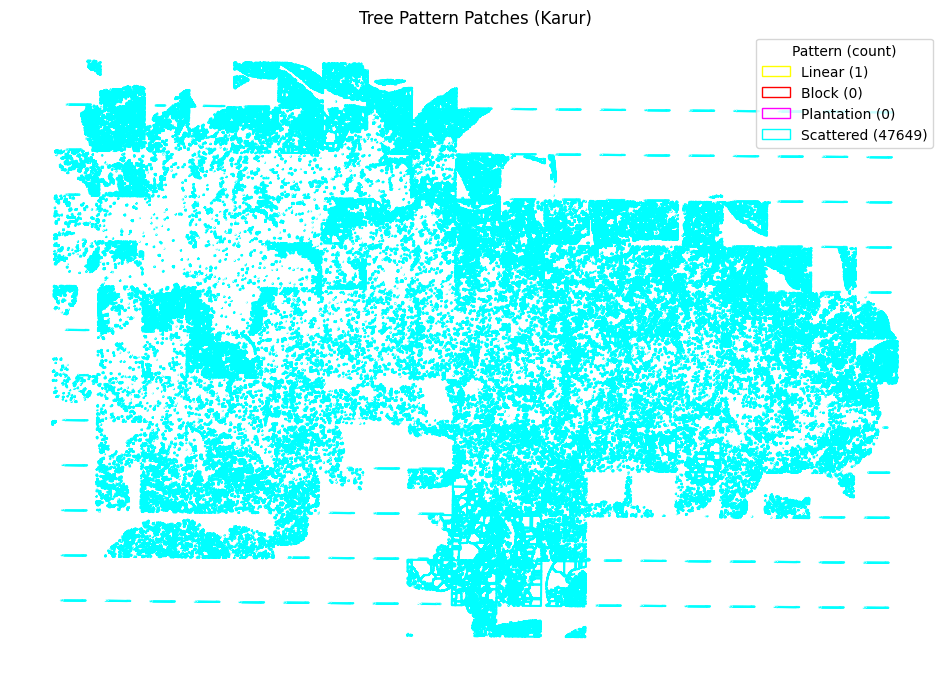

Saved → /content/drive/MyDrive/TreeProject/ndvi_seg/tree_pattern_patches.shp


In [ ]:
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from shapely.geometry import MultiPoint, Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# 1) Load per‐tree crown polygons
CROWNS = "/content/drive/MyDrive/TreeProject/ndvi_seg/tree_crowns.shp"
crowns = gpd.read_file(CROWNS).to_crs(epsg=32644)
print(f"Detected {len(crowns)} crowns")

# 2) Compute centroids (in metres)
crowns["centroid"] = crowns.geometry.centroid
pts = np.vstack([crowns.centroid.x, crowns.centroid.y]).T

# 3) DBSCAN clustering
eps_m    = 40.0  # try 40 m to get tighter groupings
clusters = DBSCAN(eps=eps_m, min_samples=2).fit_predict(pts)
crowns["cluster"] = clusters
print("Clusters:", np.unique(clusters, return_counts=True))

# 4) Build patch hulls & classify
patches = []
for cid, grp in crowns.groupby("cluster"):
    if cid == -1:
        # singletons → treat each crown as its own patch
        for poly in grp.geometry:
            patches.append({"pattern":"Scattered","geometry":poly})
    else:
        cs = pts[clusters == cid]
        hull = MultiPoint(cs).convex_hull
        # if hull is LineString or Point, buffer into a small polygon
        if not isinstance(hull, Polygon):
            hull = hull.buffer(20)  # 20 m buffer
        area = hull.area
        minx,miny,maxx,maxy = hull.bounds
        aspect = max(maxx-minx, maxy-miny) / (min(maxx-minx, maxy-miny)+1e-6)

        if len(cs)>=3:
            d,_ = NearestNeighbors(n_neighbors=2).fit(cs).kneighbors(cs)
            cv = np.std(d[:,1]) / (np.mean(d[:,1])+1e-6)
        else:
            cv = np.inf

        # adjust thresholds if needed
        if aspect > 5:
            pat = "Linear"
        elif area >= 3000 and cv < 0.3:
            pat = "Plantation"
        elif area >= 5000:
            pat = "Block"
        else:
            pat = "Scattered"

        patches.append({"pattern":pat,"geometry":hull})

# 5) Save & report counts
patch_gdf = gpd.GeoDataFrame(patches, crs=crowns.crs)
counts = patch_gdf.pattern.value_counts().to_dict()
print("Final pattern counts:", counts)

# 6) Plot with colors + legend
color_map = {"Linear":"yellow","Block":"red","Plantation":"magenta","Scattered":"cyan"}
fig, ax = plt.subplots(1,1,figsize=(12,12))
for pat, grp in patch_gdf.groupby("pattern"):
    grp.boundary.plot(ax=ax, edgecolor=color_map[pat], linewidth=1.5)
handles = [Patch(edgecolor=color_map[p],facecolor="none",label=f"{p} ({counts.get(p,0)})")
           for p in ["Linear","Block","Plantation","Scattered"]]
ax.legend(handles=handles, title="Pattern (count)", loc="upper right")
ax.set_title("Tree Pattern Patches (Karur)"); ax.axis("off")
plt.show()

# 7) Save shapefile (all geometries now valid Polygons)
OUT_SHP = "/content/drive/MyDrive/TreeProject/ndvi_seg/tree_pattern_patches.shp"
patch_gdf.to_file(OUT_SHP)
print("Saved →", OUT_SHP)


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5  Loss: 0.525
Epoch 2/5  Loss: 0.312
Epoch 3/5  Loss: 0.251
Epoch 4/5  Loss: 0.214
Epoch 5/5  Loss: 0.192
Classification done
Counts by class: Counter({np.str_('Plantation'): 152192, np.str_('Block'): 88955, np.str_('Scattered'): 78489, np.str_('Linear'): 34225})
Done – outputs in /content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized


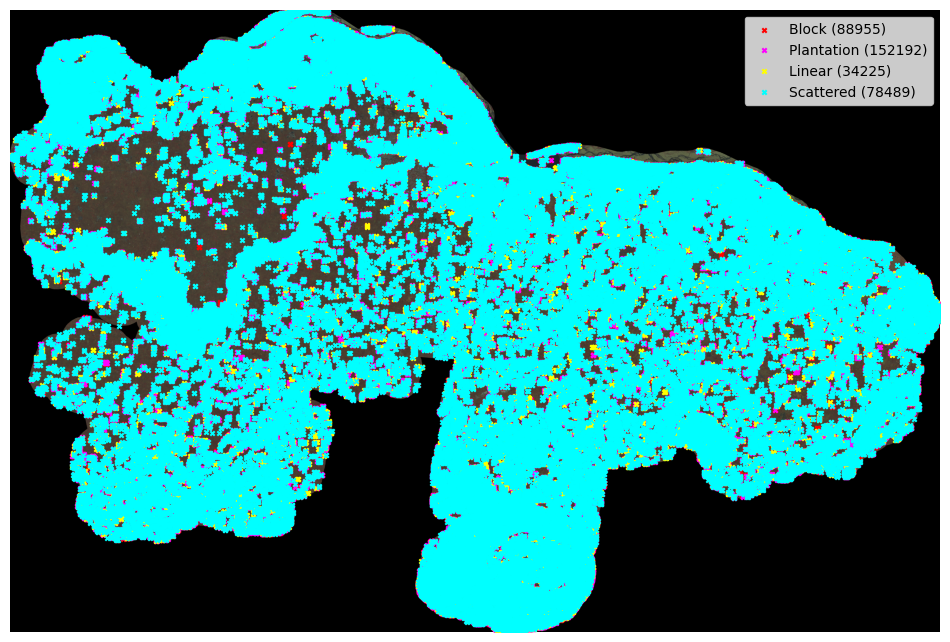

In [ ]:
# ─── 0) Install dependencies ─────────────────────────────────────────────────
!pip install --quiet rasterio geopandas shapely numpy scikit-image scipy scikit-learn torch torchvision tqdm faiss-cpu

# ─── 1) Mount Drive & Define Paths ───────────────────────────────────────────
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

BASE         = "/content/drive/MyDrive/TreeProject"
IMAGE_PATH   = os.path.join(BASE, "Karur_FalseColor.tif")
OUTPUT_DIR   = os.path.join(BASE, "deeplab_gpu_vectorized")
os.makedirs(OUTPUT_DIR, exist_ok=True)

PSEUDO_TIF   = os.path.join(OUTPUT_DIR, "ndvi_pseudo.tif")
WEIGHTS      = os.path.join(OUTPUT_DIR, "deeplab_resnet50.pth")
CANOPY_TIF   = os.path.join(OUTPUT_DIR, "canopy_mask.tif")
SHAPE_CROWNS = os.path.join(OUTPUT_DIR, "tree_crowns.shp")
CSV_OUT      = os.path.join(OUTPUT_DIR, "trees_gpu_vectorized.csv")
SHAPE_OUT    = os.path.join(OUTPUT_DIR, "trees_gpu_vectorized.shp")
PNG_OUT      = os.path.join(OUTPUT_DIR, "trees_gpu_vectorized.png")

# ─── 2) Build NDVI pseudo‐labels ───────────────────────────────────────────────
import rasterio, numpy as np
from skimage.filters import gaussian, threshold_multiotsu
from skimage.morphology import remove_small_objects, opening, closing, disk

with rasterio.open(IMAGE_PATH) as src:
    nir, red = src.read(1).astype(float), src.read(2).astype(float)
    meta, transform, crs = src.meta.copy(), src.transform, src.crs

ndvi   = (nir - red) / (nir + red + 1e-8)
ndvi_s = gaussian(ndvi, sigma=1.5)
ths    = threshold_multiotsu(ndvi_s, classes=3)
pseudo = ndvi_s >= ths[-1]
pseudo = remove_small_objects(pseudo, min_size=100)
pseudo = opening(pseudo, disk(2))
pseudo = closing(pseudo, disk(2))

meta.update(count=1, dtype="uint8")
with rasterio.open(PSEUDO_TIF, "w", **meta) as dst:
    dst.write(pseudo.astype("uint8"), 1)

# ─── 3) Train DeepLabV3‐ResNet50 on pseudo‐labels ────────────────────────────
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms.functional import to_tensor

class TileDS(Dataset):
    def __init__(self, img_tif, msk_tif, tile=512):
        import rasterio
        self.img = rasterio.open(img_tif).read([1,2,3]).astype("float32")/255.0
        self.msk = rasterio.open(msk_tif).read(1).astype("uint8")
        H,W = self.msk.shape
        self.tile, self.nx, self.ny = tile, (W+tile-1)//tile, (H+tile-1)//tile

    def __len__(self):
        return self.nx * self.ny

    def __getitem__(self, idx):
        x,y = idx % self.nx, idx // self.nx
        x0,y0 = x*self.tile, y*self.tile
        x1 = min(x0+self.tile, self.msk.shape[1])
        y1 = min(y0+self.tile, self.msk.shape[0])
        im = self.img[:, y0:y1, x0:x1].transpose(1,2,0)
        ms = self.msk[y0:y1, x0:x1]
        ph,pw = self.tile-(y1-y0), self.tile-(x1-x0)
        im = np.pad(im, ((0,ph),(0,pw),(0,0)), mode="constant")
        ms = np.pad(ms, ((0,ph),(0,pw)), mode="constant")
        return to_tensor(im), torch.from_numpy(ms).long()

ds     = TileDS(IMAGE_PATH, PSEUDO_TIF)
loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(256,1,1)
model.to(device)

opt  = optim.Adam(model.parameters(), lr=1e-4)
crit = nn.BCEWithLogitsLoss()

for epoch in range(5):
    model.train(); tot=0
    for im,ms in loader:
        im,ms = im.to(device), ms.unsqueeze(1).float().to(device)
        opt.zero_grad()
        out = model(im)["out"]
        loss= crit(out,ms)
        loss.backward(); opt.step()
        tot += loss.item()
    print(f"Epoch {epoch+1}/5  Loss: {tot/len(loader):.3f}")

torch.save(model.state_dict(), WEIGHTS)

# ─── 4) Inference Full‐scene Canopy Mask ──────────────────────────────────────
model.eval()
with rasterio.open(PSEUDO_TIF) as src:
    H,W = src.height, src.width

prob = np.zeros((H,W), float)
with torch.no_grad():
    for i in range(len(ds)):
        im,_ = ds[i]
        p = model(im.unsqueeze(0).to(device))["out"].sigmoid()[0,0].cpu().numpy()
        x,y = i%ds.nx, i//ds.nx
        x0,y0 = x*ds.tile, y*ds.tile
        hr,wr = min(ds.tile,H-y0), min(ds.tile,W-x0)
        prob[y0:y0+hr, x0:x0+wr] = p[:hr,:wr]

mask_dl = prob >= 0.5
meta.update(count=1, dtype="uint8")
with rasterio.open(CANOPY_TIF, "w", **meta) as dst:
    dst.write(mask_dl.astype("uint8"),1)

# ─── 5) NDVI smoothing & local-max detection ─────────────────────────────────
import torch.nn.functional as F, time
import torch

# load false-color bands
with rasterio.open(IMAGE_PATH) as src:
    b8,b4,b2 = src.read([1,2,3]).astype("float32")
    transform, crs = src.transform, src.crs

ndvi = (b8 - b4) / (b8 + b4 + 1e-10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t_ndvi = torch.from_numpy(ndvi[None,None]).to(device)

pixel_res  = 10.0
crown_r_m  = 2.0
NDVI_THR   = 0.3
block_m    = 20.0
linear_m   = 50.0
plant_cv   = 0.25
angle_tol  = 20.0

# derived in px
crown_r_px = max(1, int(round(crown_r_m/pixel_res)))
block_px   = block_m/pixel_res
linear_px  = linear_m/pixel_res

sigma = crown_r_px/2
K     = 2*crown_r_px+1
coords = torch.arange(K, device=device).float() - crown_r_px
g1     = torch.exp(-0.5*(coords/sigma)**2)
kernel = (g1[:,None]*g1[None,:]) / g1.sum()
kernel = kernel[None,None]

smoothed  = F.conv2d(t_ndvi, kernel, padding=crown_r_px)[0,0]
canopy    = (smoothed >= NDVI_THR) & torch.from_numpy(mask_dl).to(device)
pooled    = F.max_pool2d(smoothed[None,None], K, 1, crown_r_px)[0,0]
local_max = (smoothed==pooled) & canopy

peaks      = torch.nonzero(local_max, as_tuple=False)
coords_full= peaks[:,[1,0]].float().to(device)
P          = coords_full.shape[0]

# ─── 6) Vectorized batch k-NN + classification ──────────────────────────────
import numpy as np
from collections import Counter

BATCH    = 2048
patterns = torch.empty(P, dtype=torch.int8, device=device)

for st in range(0,P,BATCH):
    ed    = min(st+BATCH,P)
    batch = coords_full[st:ed]
    dists = torch.cdist(batch, coords_full)
    idxs  = torch.arange(st,ed,device=device)
    dists[torch.arange(ed-st,device=device), idxs] = float('inf')
    vals, nbr = torch.topk(dists, 3, dim=1, largest=False)

    d1 = vals[:,0].sqrt(); d2 = vals[:,1].sqrt(); d3 = vals[:,2].sqrt()
    neigh   = coords_full[nbr[:,:2]]
    vecs    = neigh - batch.unsqueeze(1)
    angs    = (torch.atan2(vecs[:,:,1],vecs[:,:,0])*(180/np.pi)+360)%180
    ang_dev = (angs[:,0]-angs[:,1]).abs()
    cv      = vals.std(dim=1)/(vals.mean(dim=1)+1e-6)

    cls = torch.full((ed-st,),3,device=device,dtype=torch.int8)
    cls[(d1<=block_px)&(d2<=block_px)]                         = 0
    cls[(d1<=linear_px)&(d2<=linear_px)&(ang_dev<=angle_tol)]  = 2
    cls[(cv<=plant_cv)&(d1<=2*block_px)]                       = 1

    patterns[st:ed] = cls

print("Classification done")

coords_np    = coords_full.cpu().numpy()
labels       = np.array(['Block','Plantation','Linear','Scattered'])[patterns.cpu().numpy()]
counts       = Counter(labels)
print("Counts by class:", counts)

# ─── 7) Annotate & save PNG ─────────────────────────────────────────────────
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(12,12))
rgb = np.stack([(b8-b8.min())/np.ptp(b8),
                (b4-b4.min())/np.ptp(b4),
                (b2-b2.min())/np.ptp(b2)],axis=-1)
ax.imshow(rgb)
colors = {'Block':'red','Plantation':'magenta','Linear':'yellow','Scattered':'cyan'}
for cls in colors:
    sel = labels==cls
    ax.scatter(coords_np[sel,0], coords_np[sel,1],
               c=colors[cls], s=10, marker='x', label=f"{cls} ({counts[cls]})")
ax.legend(loc='upper right'); ax.axis('off')
fig.savefig(PNG_OUT, dpi=300, bbox_inches='tight')

# ─── 8) Export CSV & Shapefile ───────────────────────────────────────────────
import csv
from shapely.geometry import Point
import geopandas as gpd

with open(CSV_OUT,'w',newline='') as f:
    w=csv.writer(f); w.writerow(['lon','lat','class'])
    for (x,y),lab in zip(coords_np,labels):
        lon,lat = rasterio.transform.xy(transform,int(y),int(x))
        w.writerow([lon,lat,lab])

gdf = gpd.GeoDataFrame({'class':labels},
    geometry=[Point(rasterio.transform.xy(transform,int(y),int(x))) for x,y in coords_np],
    crs=crs)
gdf.to_file(SHAPE_OUT)

print("Done – outputs in", OUTPUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 78.3 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 145MB/s]


Epoch 1/5  Loss: 0.481
Epoch 2/5  Loss: 0.293
Epoch 3/5  Loss: 0.229
Epoch 4/5  Loss: 0.206
Epoch 5/5  Loss: 0.184
Counts by class: Counter({np.str_('Plantation'): 128499, np.str_('Block'): 76212, np.str_('Scattered'): 68217, np.str_('Linear'): 29749})


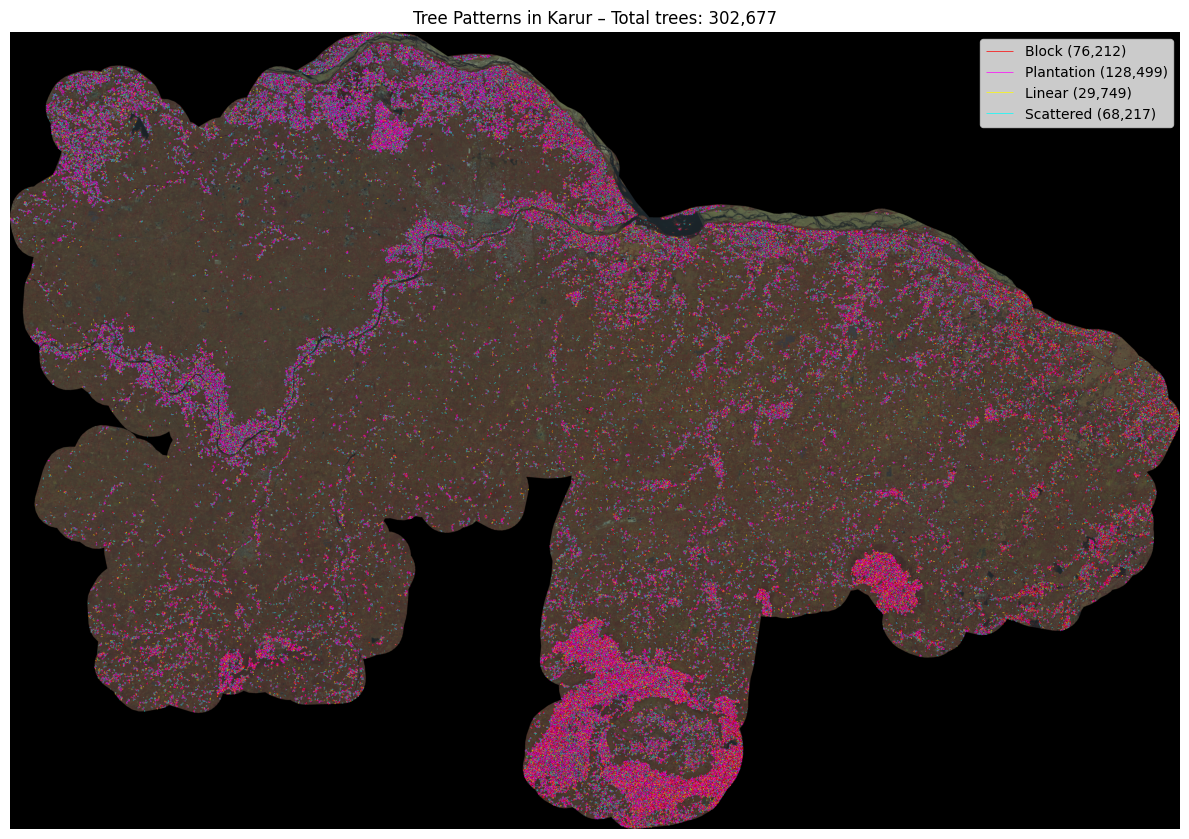

In [ ]:
# ─── 0) Install dependencies ─────────────────────────────────────────────────
!pip install --quiet rasterio geopandas shapely numpy scikit-image scipy scikit-learn torch torchvision tqdm faiss-cpu

# ─── 1) Mount Drive & Define Paths ───────────────────────────────────────────
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

BASE       = "/content/drive/MyDrive/TreeProject"
IMAGE_PATH = os.path.join(BASE, "Karur_FalseColor.tif")
OUT_DIR    = os.path.join(BASE, "deeplab_gpu_vectorized")
os.makedirs(OUT_DIR, exist_ok=True)

PSEUDO_TIF   = os.path.join(OUT_DIR, "ndvi_pseudo.tif")
WEIGHTS      = os.path.join(OUT_DIR, "deeplab_resnet50.pth")
CANOPY_TIF   = os.path.join(OUT_DIR, "canopy_mask.tif")
SHAPE_CROWNS = os.path.join(OUT_DIR, "tree_crowns.shp")
CSV_OUT      = os.path.join(OUT_DIR, "trees_gpu_vectorized.csv")
SHAPE_OUT    = os.path.join(OUT_DIR, "trees_gpu_vectorized.shp")
PNG_OUT      = os.path.join(OUT_DIR, "trees_gpu_vectorized.png")

# ─── 2) Build NDVI pseudo-labels ───────────────────────────────────────────────
import rasterio, numpy as np
from skimage.filters import gaussian, threshold_multiotsu
from skimage.morphology import remove_small_objects, opening, closing, disk

with rasterio.open(IMAGE_PATH) as src:
    nir, red = src.read(1).astype(float), src.read(2).astype(float)
    meta, transform, crs = src.meta.copy(), src.transform, src.crs

ndvi   = (nir - red) / (nir + red + 1e-8)
ndvi_s = gaussian(ndvi, sigma=1.5)
ths    = threshold_multiotsu(ndvi_s, classes=3)
pseudo = ndvi_s >= ths[-1]
pseudo = remove_small_objects(pseudo, min_size=100)
pseudo = opening(pseudo, disk(2))
pseudo = closing(pseudo, disk(2))

meta.update(count=1, dtype="uint8")
with rasterio.open(PSEUDO_TIF, "w", **meta) as dst:
    dst.write(pseudo.astype("uint8"), 1)

# ─── 3) Train DeepLabV3-ResNet50 on pseudo-labels ────────────────────────────
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms.functional import to_tensor

class TileDS(Dataset):
    def __init__(self, img_tif, msk_tif, tile=512):
        import rasterio
        self.img = rasterio.open(img_tif).read([1,2,3]).astype("float32")/255.0
        self.msk = rasterio.open(msk_tif).read(1).astype("uint8")
        H,W = self.msk.shape
        self.tile, self.nx, self.ny = tile, (W+tile-1)//tile, (H+tile-1)//tile

    def __len__(self):
        return self.nx * self.ny

    def __getitem__(self, idx):
        x,y = idx % self.nx, idx // self.nx
        x0,y0 = x*self.tile, y*self.tile
        x1 = min(x0+self.tile, self.msk.shape[1])
        y1 = min(y0+self.tile, self.msk.shape[0])
        im = self.img[:, y0:y1, x0:x1].transpose(1,2,0)
        ms = self.msk[y0:y1, x0:x1]
        ph,pw = self.tile-(y1-y0), self.tile-(x1-x0)
        im = np.pad(im, ((0,ph),(0,pw),(0,0)), mode="constant")
        ms = np.pad(ms, ((0,ph),(0,pw)), mode="constant")
        return to_tensor(im), torch.from_numpy(ms).long()

ds     = TileDS(IMAGE_PATH, PSEUDO_TIF)
loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(256,1,1)
model.to(device)

opt  = optim.Adam(model.parameters(), lr=1e-4)
crit = nn.BCEWithLogitsLoss()

for epoch in range(5):
    model.train(); total_loss = 0
    for im,ms in loader:
        im,ms = im.to(device), ms.unsqueeze(1).float().to(device)
        opt.zero_grad()
        out = model(im)["out"]
        loss= crit(out,ms)
        loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5  Loss: {total_loss/len(loader):.3f}")

torch.save(model.state_dict(), WEIGHTS)

# ─── 4) Inference Full-scene Canopy Mask ──────────────────────────────────────
model.eval()
with rasterio.open(PSEUDO_TIF) as src:
    H,W = src.height, src.width

prob = np.zeros((H,W), float)
with torch.no_grad():
    for i in range(len(ds)):
        im,_ = ds[i]
        p    = model(im.unsqueeze(0).to(device))["out"].sigmoid()[0,0].cpu().numpy()
        x,y  = i % ds.nx, i // ds.nx
        x0,y0= x*ds.tile, y*ds.tile
        hr,wr= min(ds.tile,H-y0), min(ds.tile,W-x0)
        prob[y0:y0+hr, x0:x0+wr] = p[:hr,:wr]

mask_dl = prob >= 0.5
meta.update(count=1, dtype="uint8")
with rasterio.open(CANOPY_TIF, "w", **meta) as dst:
    dst.write(mask_dl.astype("uint8"),1)

# ─── 5) NDVI smoothing & local-max detection on GPU ──────────────────────────
import torch.nn.functional as F, time
import torch

with rasterio.open(IMAGE_PATH) as src:
    b8,b4,b2 = src.read([1,2,3]).astype("float32")
    transform, crs = src.transform, src.crs

ndvi    = (b8 - b4) / (b8 + b4 + 1e-10)
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
t_ndvi  = torch.from_numpy(ndvi[None,None]).to(device)

# thresholds
pixel_res  = 10.0; crown_r_m=2.0; NDVI_THR=0.3
block_m    = 20.0; linear_m=50.0; plant_cv=0.25; angle_tol=20.0
crown_r_px = max(1, int(round(crown_r_m/pixel_res)))
block_px   = block_m/pixel_res
linear_px  = linear_m/pixel_res

# Gaussian
sigma = crown_r_px/2
K     = 2*crown_r_px+1
coords= torch.arange(K, device=device).float()-crown_r_px
g1    = torch.exp(-0.5*(coords/sigma)**2)
kernel= (g1[:,None]*g1[None,:])/g1.sum()
kernel= kernel[None,None]

smoothed  = F.conv2d(t_ndvi, kernel, padding=crown_r_px)[0,0]
canopy    = (smoothed>=NDVI_THR) & torch.from_numpy(mask_dl).to(device)
pooled    = F.max_pool2d(smoothed.unsqueeze(0).unsqueeze(0),
                         K,1, crown_r_px)[0,0]
local_max = (smoothed==pooled) & canopy

peaks      = torch.nonzero(local_max, as_tuple=False)
coords_full= peaks[:,[1,0]].float().to(device)
P          = coords_full.shape[0]

# ─── 6) Batch k-NN classification ────────────────────────────────────────────
import numpy as np
from collections import Counter

BATCH    = 2048
patterns = torch.empty(P, dtype=torch.int8, device=device)

for st in range(0,P,BATCH):
    ed    = min(st+BATCH,P)
    batch = coords_full[st:ed]
    dists = torch.cdist(batch, coords_full)
    idxs  = torch.arange(st,ed,device=device)
    dists[torch.arange(ed-st,device=device), idxs]=float('inf')
    vals,nbr = torch.topk(dists,3,dim=1,largest=False)

    d1=vals[:,0].sqrt(); d2=vals[:,1].sqrt()
    neigh   = coords_full[nbr[:,:2]]
    vecs    = neigh - batch.unsqueeze(1)
    angs    = (torch.atan2(vecs[:,:,1],vecs[:,:,0])*(180/np.pi)+360)%180
    ang_dev = (angs[:,0]-angs[:,1]).abs()
    cv      = vals.std(dim=1)/(vals.mean(dim=1)+1e-6)

    cls = torch.full((ed-st,),3,device=device,dtype=torch.int8)
    cls[(d1<=block_px)&(d2<=block_px)]                         = 0
    cls[(d1<=linear_px)&(d2<=linear_px)&(ang_dev<=angle_tol)]  = 2
    cls[(cv<=plant_cv)&(d1<=2*block_px)]                       = 1

    patterns[st:ed] = cls

coords_np = coords_full.cpu().numpy()
labels    = np.array(['Block','Plantation','Linear','Scattered'])[patterns.cpu().numpy()]
counts    = Counter(labels)
print("Counts by class:", counts)

# ─── 7) Export CSV & Shapefile of points ────────────────────────────────────
import csv
from shapely.geometry import Point
import geopandas as gpd

with open(CSV_OUT,'w',newline='') as f:
    w=csv.writer(f); w.writerow(['lon','lat','class'])
    for (x,y),lab in zip(coords_np,labels):
        lon,lat = rasterio.transform.xy(transform,int(y),int(x))
        w.writerow([lon,lat,lab])

gdf = gpd.GeoDataFrame({'class':labels},
    geometry=[Point(rasterio.transform.xy(transform,int(y),int(x))) for x,y in coords_np],
    crs=crs)
gdf.to_file(SHAPE_OUT)

# ─── 8) Build true buffer polygons (reproject to UTM, buffer, back) ─────────
import geopandas as gpd

# load the detected points
pts = gpd.read_file(SHAPE_OUT)  # geometry=Point(lon,lat), in epsg:4326

# choose an appropriate local projected CRS; Karur, Tamil Nadu → UTM zone 44N
utm_crs = "EPSG:32644"

# reproject to UTM for metric buffering
pts_utm = pts.to_crs(utm_crs)

# buffer radius in metres (e.g. 5 m for approx crown)
buffer_radius = 5.0

# create little circular polygons around each treetop
pts_utm["geometry"] = pts_utm.geometry.buffer(buffer_radius)

# project the polygons back to original geographic CRS
crowns = pts_utm.to_crs(crs)

# overwrite crown‐shapefile with real polygons
crowns.to_file(SHAPE_CROWNS)

# ─── 9) Plot with polygons instead of crosses ────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

# load & normalize RGB
with rasterio.open(IMAGE_PATH) as src:
    R = (src.read(1) - src.read(1).min()) / np.ptp(src.read(1))
    G = (src.read(2) - src.read(2).min()) / np.ptp(src.read(2))
    B = (src.read(3) - src.read(3).min()) / np.ptp(src.read(3))
    extent = (
        src.transform[2],
        src.transform[2] + src.width  * src.transform[0],
        src.transform[5] + src.height * src.transform[4],
        src.transform[5],
    )

rgb = np.dstack([R, G, B])

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(rgb, extent=extent)

# plot each class with its own color and count
colors = {'Block':'red','Plantation':'magenta','Linear':'yellow','Scattered':'cyan'}
for cls, col in colors.items():
    subset = crowns[crowns['class'] == cls]
    subset.boundary.plot(ax=ax, edgecolor=col, linewidth=0.5,
                         label=f"{cls} ({len(subset):,})")

ax.set_title(f"Tree Patterns in Karur – Total trees: {len(crowns):,}")
ax.axis('off')
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=300)
plt.show()



ModuleNotFoundError: No module named 'grounded_sam2'

In [ ]:
%%bash
pip install --quiet streamlit pyngrok


In [ ]:
# app.py
import streamlit as st

st.title("Tree Classifier")
st.write("🍃 Your segmentation GUI goes here.")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
%%bash
# Install
pip install rasterio geopandas shapely numpy scikit-image scipy scikit-learn torch torchvision tqdm faiss-cpu streamlit pyngrok
pip install --quiet streamlit pyngrok

# Launch (background)
nohup streamlit run app.py \
  --server.port=8501 \
  --server.enableCORS=false \
  --server.enableXsrfProtection=false \
  &> streamlit.log &


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%%bash
# You should see a process listening on :8501
ps aux | grep streamlit
netstat -plant | grep 8501


root       12642  5.5  5.4 4339820 718316 ?      Sl   14:14   0:12 /usr/bin/python3 /usr/local/bin/streamlit run app.py --server.port=8501 --server.enableCORS=false --server.enableXsrfProtection=false
root       13674  0.0  0.0   6484  2300 ?        S    14:18   0:00 grep streamlit
tcp        0      0 0.0.0.0:8501            0.0.0.0:*               LISTEN      12642/python3       
tcp6       0      0 :::8501                 :::*                    LISTEN      12642/python3       


In [ ]:
!ngrok config add-authtoken

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


Process is interrupted.


In [ ]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Open new tunnel to localhost:8501
url = ngrok.connect(8501, "http")
print("→", url)


→ NgrokTunnel: "https://8459-34-143-167-249.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
# app.py
import streamlit as st
import torch
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

from torchvision.models.segmentation import deeplabv3_resnet50
from skimage.filters import gaussian, threshold_multiotsu
from skimage.morphology import remove_small_objects, opening, closing, disk
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import torch.nn.functional as F

st.set_page_config(layout="wide")
st.title("🌳 Karur Tree‐Pattern Classifier")

# ────────────────────────────────────────────────────────────────────────────────
# 1) Sidebar: Upload a 10 m Sentinel-2 False-Color GeoTIFF (NIR=band1, Red=band2, Blue=band3)
st.sidebar.header("1) Upload False-Color GeoTIFF")
uploaded_file = st.sidebar.file_uploader(
    "Choose a GeoTIFF (NIR, Red, Blue)",
    type=["tif","tiff"]
)
if uploaded_file is None:
    st.sidebar.info("🔸 Please upload a 10 m false-color GeoTIFF first.")
    st.stop()

# ────────────────────────────────────────────────────────────────────────────────
# 2) Load pre‐trained DeepLabV3-ResNet50 canopy model (filter out aux keys)
@st.cache_resource(show_spinner=False)
def load_deeplab(weights_path: str, device: str):
    model = deeplabv3_resnet50(pretrained=False)
    # Replace final classifier to output a single-channel (binary) mask
    model.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=1)
    model.to(device)
    # Load state_dict, ignoring any "aux_classifier.*" keys
    ckpt = torch.load(weights_path, map_location=device)
    filtered = {k: v for k, v in ckpt.items() if not k.startswith("aux_classifier.")}
    model.load_state_dict(filtered, strict=False)
    model.eval()
    return model

device = "cuda" if torch.cuda.is_available() else "cpu"
st.sidebar.write(f"▶️ Running on: **{device.upper()}**")

DEEPLAB_WEIGHTS = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/deeplab_resnet50.pth"
model = load_deeplab(DEEPLAB_WEIGHTS, device)
st.sidebar.success("✅ DeepLabV3 model loaded")

# ────────────────────────────────────────────────────────────────────────────────
# 3) Read the uploaded GeoTIFF (bands: 1=NIR, 2=Red, 3=Blue)
with rasterio.open(uploaded_file) as src:
    b8 = src.read(1).astype("float32")   # NIR
    b4 = src.read(2).astype("float32")   # Red
    b2 = src.read(3).astype("float32")   # Blue
    transform, crs = src.transform, src.crs
    H, W = b8.shape

# Build a normalized “RGB” for plotting: R = normalized NIR, G = normalized Red, B = normalized Blue
R_norm = (b8 - b8.min()) / (np.ptp(b8) + 1e-8)
G_norm = (b4 - b4.min()) / (np.ptp(b4) + 1e-8)
B_norm = (b2 - b2.min()) / (np.ptp(b2) + 1e-8)
rgb_arr = np.dstack([R_norm, G_norm, B_norm]).astype("float32")  # shape (H, W, 3)

# ────────────────────────────────────────────────────────────────────────────────
# 4) Build NDVI pseudo-labels via skimage
with st.spinner("🔸 Creating NDVI pseudo-labels…"):
    ndvi = (b8 - b4) / (b8 + b4 + 1e-8)
    ndvi_s = gaussian(ndvi, sigma=1.5)
    ths = threshold_multiotsu(ndvi_s, classes=3)
    pseudo = ndvi_s >= ths[-1]
    pseudo = remove_small_objects(pseudo, min_size=100)
    pseudo = opening(pseudo, disk(2))
    pseudo = closing(pseudo, disk(2))
st.success("✅ NDVI pseudo-label mask ready")

# ────────────────────────────────────────────────────────────────────────────────
# 5) DeepLab full-scene inference → refined canopy mask (binary)
with st.spinner("🔸 Running DeepLabV3 on GPU…"):
    canopy_mask = np.zeros((H, W), dtype=bool)
    tile = 512
    nx = (W + tile - 1) // tile
    ny = (H + tile - 1) // tile

    for yy in range(ny):
        for xx in range(nx):
            x0, y0 = xx * tile, yy * tile
            x1 = min(x0 + tile, W)
            y1 = min(y0 + tile, H)

            patch = rgb_arr[y0:y1, x0:x1, :]  # shape (h, w, 3)
            ph = tile - (y1 - y0)
            pw = tile - (x1 - x0)
            patch_pad = np.pad(patch,
                               ((0, ph), (0, pw), (0, 0)),
                               mode="constant").astype("float32")
            # shape → (tile, tile, 3). Convert to torch: (1, 3, tile, tile)
            t = torch.from_numpy(patch_pad.transpose(2, 0, 1)).unsqueeze(0).to(device)
            with torch.no_grad():
                out = model(t)["out"].sigmoid()[0, 0].detach().cpu().numpy()
            out_crop = out[: (y1 - y0), : (x1 - x0)]
            canopy_mask[y0:y1, x0:x1] = out_crop >= 0.5

st.success("✅ DeepLab canopy mask complete")

# ────────────────────────────────────────────────────────────────────────────────
# 6) On GPU: NDVI smoothing + local-max detection under the canopy_mask
with st.spinner("🔸 Detecting treetops (NDVI smoothing + local-max)…"):
    ndvi_t = torch.from_numpy(ndvi[None, None]).to(device)

    # thresholds (metres → pixels)
    pixel_res = 10.0
    crown_r_m = 2.0
    NDVI_THR = 0.3
    block_m = 20.0
    linear_m = 50.0
    plant_cv = 0.25
    angle_tol = 20.0

    crown_r_px = max(1, int(round(crown_r_m / pixel_res)))
    block_px = block_m / pixel_res
    linear_px = linear_m / pixel_res

    sigma = crown_r_px / 2
    K = 2 * crown_r_px + 1
    coords1d = torch.arange(K, device=device).float() - crown_r_px
    g1 = torch.exp(-0.5 * (coords1d / sigma) ** 2)
    kernel = (g1[:, None] * g1[None, :]) / g1.sum()
    kernel = kernel[None, None]  # shape (1, 1, K, K)

    # 1) smooth NDVI
    smoothed = F.conv2d(ndvi_t, kernel, padding=crown_r_px)[0, 0]  # (H, W)

    # 2) apply NDVI threshold + DeepLab canopy
    canopy_gpu = (smoothed >= NDVI_THR) & torch.from_numpy(canopy_mask).to(device)

    # 3) local-max pooling
    pooled = F.max_pool2d(smoothed.unsqueeze(0).unsqueeze(0),
                          kernel_size=K, stride=1, padding=crown_r_px)[0, 0]
    local_max = (smoothed == pooled) & canopy_gpu

    peaks = torch.nonzero(local_max, as_tuple=False)  # shape (P, 2) = (y, x)
    coords_full = peaks[:, [1, 0]].float().to(device)  # (P, 2) in (x, y)
    P = coords_full.shape[0]

st.success(f"✅ Found {P:,} treetop candidates")

# ────────────────────────────────────────────────────────────────────────────────
# 7) On CPU: classify each treetop via 3-NN → Block / Plantation / Linear / Scattered
coords_np = coords_full.cpu().numpy()
labels_list = []

if P == 0:
    st.warning("⚠️ No treetops detected. Cannot classify.")
else:
    nbrs = NearestNeighbors(n_neighbors=4).fit(coords_np)
    dists_all, idxs_all = nbrs.kneighbors(coords_np)

    for i in range(P):
        d1, d2, d3 = dists_all[i, 0], dists_all[i, 1], dists_all[i, 2]
        pts_neigh = coords_np[idxs_all[i, :2]]  # shape (2, 2)
        dx1, dy1 = pts_neigh[0, 0] - coords_np[i, 0], pts_neigh[0, 1] - coords_np[i, 1]
        dx2, dy2 = pts_neigh[1, 0] - coords_np[i, 0], pts_neigh[1, 1] - coords_np[i, 1]
        ang1 = (np.degrees(np.arctan2(dy1, dx1)) + 360) % 180
        ang2 = (np.degrees(np.arctan2(dy2, dx2)) + 360) % 180
        ang_dev = abs(ang1 - ang2)
        cv_val = np.std([d1, d2, d3]) / (np.mean([d1, d2, d3]) + 1e-6)

        if (d1 <= block_px) and (d2 <= block_px):
            labels_list.append("Block")
        elif (cv_val <= plant_cv) and (d1 <= 2 * block_px):
            labels_list.append("Plantation")
        elif (d1 <= linear_px) and (d2 <= linear_px) and (ang_dev <= angle_tol):
            labels_list.append("Linear")
        else:
            labels_list.append("Scattered")

cnt = Counter(labels_list)
st.write("▶️ Classification counts:", dict(cnt))

# ────────────────────────────────────────────────────────────────────────────────
# 8) Export points → CSV + point Shapefile
CSV_OUT = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/trees_gpu_vectorized.csv"
SHP_OUT = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/trees_gpu_vectorized.shp"

with open(CSV_OUT, "w", newline="") as f:
    w = __import__("csv").writer(f)
    w.writerow(["lon", "lat", "class"])
    for (xpix, ypix), lab in zip(coords_np, labels_list):
        lon, lat = rasterio.transform.xy(transform, int(ypix), int(xpix))
        w.writerow([lon, lat, lab])

gdf_pts = gpd.GeoDataFrame(
    {"class": labels_list},
    geometry=[Point(rasterio.transform.xy(transform, int(yp), int(xp))) for xp, yp in coords_np],
    crs=crs,
)
gdf_pts.to_file(SHP_OUT)
st.success(f"✅ Saved point Shapefile → `{SHP_OUT}`")

# ────────────────────────────────────────────────────────────────────────────────
# 9) Build 5 m buffer polygons (UTM 44N → geo)
if P > 0:
    utm_crs = "EPSG:32644"  # Karur, TN → UTM zone 44N
    pts_utm = gdf_pts.to_crs(utm_crs)
    pts_utm["geometry"] = pts_utm.geometry.buffer(5.0)  # 5 m radius
    crowns = pts_utm.to_crs(crs)
    CROWN_SHP = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/tree_crowns.shp"
    crowns.to_file(CROWN_SHP)
    st.success(f"✅ Saved buffered crowns → `{CROWN_SHP}`")
else:
    crowns = gpd.GeoDataFrame(columns=["class", "geometry"], crs=crs)
    CROWN_SHP = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/tree_crowns.shp"
    crowns.to_file(CROWN_SHP)
    st.warning("ℹ️ No crowns to buffer; created empty shapefile.")

# ────────────────────────────────────────────────────────────────────────────────
# 10) Plot final polygons (instead of crosses) on top of RGB background
PNG_OUT = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/trees_gpu_vectorized.png"
fig, ax = plt.subplots(figsize=(10, 10))

extent = (
    transform[2],
    transform[2] + W * transform[0],
    transform[5] + H * transform[4],
    transform[5],
)
ax.imshow(rgb_arr, extent=extent)

colors = {"Block": "red", "Plantation": "magenta", "Linear": "yellow", "Scattered": "cyan"}
for pat, col in colors.items():
    subset = crowns[crowns["class"] == pat]
    if len(subset) > 0:
        subset.boundary.plot(ax=ax, edgecolor=col, linewidth=0.5,
                             label=f"{pat} ({cnt.get(pat, 0):,})")

ax.set_title(f"Tree Patterns in Karur  –  Total trees: {len(crowns):,}")
ax.axis("off")
ax.legend(loc="upper right")
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=300)
st.pyplot(fig)

# ────────────────────────────────────────────────────────────────────────────────
# 11) Offer GeoPackage download of buffered crowns
GPKG_OUT = "/content/drive/MyDrive/TreeProject/deeplab_gpu_vectorized/tree_crowns.gpkg"
crowns.to_file(GPKG_OUT, driver="GPKG")
with open(GPKG_OUT, "rb") as f:
    st.download_button(
        label="⬇️ Download tree_crowns.gpkg",
        data=f,
        file_name="karur_tree_crowns.gpkg",
        mime="application/x-gpkg",
    )

# ────────────────────────────────────────────────────────────────────────────────
# 12) (Optional) In Colab, to obtain a public URL via ngrok, uncomment:
# from pyngrok import ngrok
# ngrok.kill()
# public_url = ngrok.connect(8501, "http")
# st.write(f"🌐 Public URL → {public_url}")


ModuleNotFoundError: No module named 'streamlit'